# Task 1. Base class

In [1]:
import numpy as np
import pandas as pd

class BaseCluster:
    def fit(self, data):
        raise NotImplementedError("This method should be implemented in each subclass.")

    def predict(self, data):
        raise NotImplementedError("This method should be implemented in each subclass.")

# Task 2. Kmeans

In [3]:
class KMeans(BaseCluster):
    def __init__(self, n_clusters=2, max_iter=100, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids = None

    def initialize_centroids(self, data):
        np.random.seed(42)
        random_indices = np.random.choice(len(data), self.n_clusters, replace=False)
        self.centroids = data[random_indices]

    def fit(self, data):
        # Initialize centroids
        self.initialize_centroids(data)

        for _ in range(self.max_iter):
            clusters = self._assign_clusters(data)
            new_centroids = np.array([data[clusters == k].mean(axis=0) for k in range(self.n_clusters)])

            if np.all(np.linalg.norm(new_centroids - self.centroids, axis=1) <= self.tol):
                break

            self.centroids = new_centroids

    def predict(self, data):
        return self._assign_clusters(data)

    def _assign_clusters(self, data):
        distances = np.linalg.norm(data - self.centroids[:, np.newaxis], axis=2)
        return np.argmin(distances, axis=0)

In [104]:
from sklearn.datasets import make_blobs

X, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
predictions = kmeans.predict(X)

predictions[:10], kmeans.centroids

(array([1, 3, 2, 3, 1, 1, 0, 2, 3, 3], dtype=int64),
 array([[-1.58438467,  2.83081263],
        [ 1.98258281,  0.86771314],
        [ 0.94973532,  4.41906906],
        [-1.37324398,  7.75368871]]))

In [105]:
import matplotlib.pyplot as plt

def plot_clusters(data, predictions, centroids=None, model=None, n_points=1000, plot_points=False, title='Clusters Visualization'):
    plt.figure(figsize=(12, 8))
    plt.scatter(data[:, 0], data[:, 1], c=predictions, s=50, cmap='viridis')
    if centroids is not None:
        plt.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', alpha=0.7, marker='X')

    if model is not None:
        x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
        y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, n_points), np.linspace(y_min, y_max, n_points))
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, alpha=0.2, cmap='viridis')

        if plot_points:
            plt.scatter(xx.ravel(), yy.ravel(), c=Z.ravel(), s=1, cmap='viridis')

    plt.title(title)
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.show()

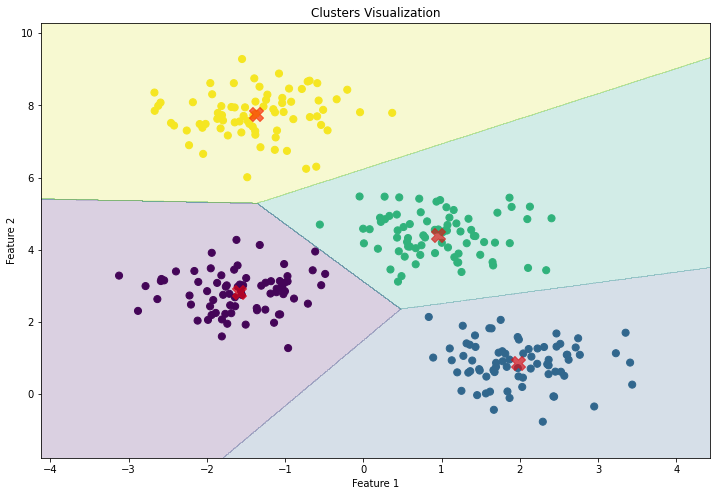

In [106]:
plot_clusters(X, predictions, kmeans.centroids, kmeans)

# Task 2.5 Kmeans++

In [107]:
class KMeansPlusPlus(KMeans):
    def initialize_centroids(self, data):
        np.random.seed(42)
        centroids = [data[np.random.choice(len(data))]]

        for _ in range(1, self.n_clusters):
            distances = np.array([min(np.linalg.norm(x - centroid) for centroid in centroids) for x in data])
            probabilities = distances / distances.sum()
            cumulative_probabilities = probabilities.cumsum()
            r = np.random.rand()

            for i, p in enumerate(cumulative_probabilities):
                if r < p:
                    centroids.append(data[i])
                    break

        self.centroids = np.array(centroids)

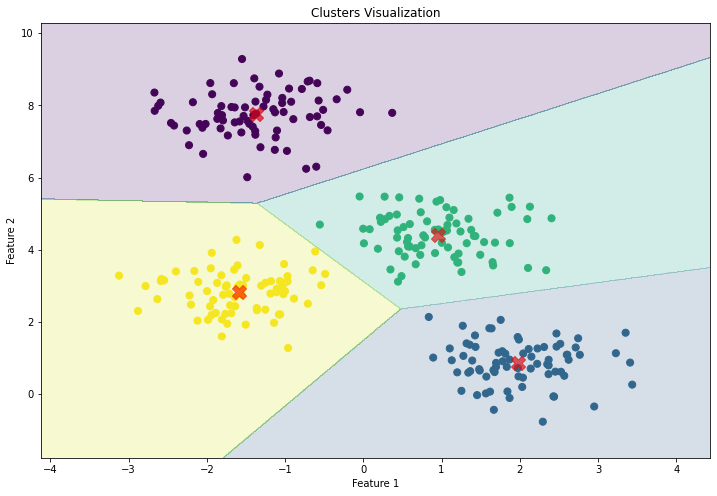

In [108]:
kmeans_plus_plus = KMeansPlusPlus(n_clusters=4)
kmeans_plus_plus.fit(X)
predictions_plus_plus = kmeans_plus_plus.predict(X)

plot_clusters(X, predictions_plus_plus, kmeans_plus_plus.centroids, kmeans_plus_plus)

## Comparison with KMeans++ from sklearn

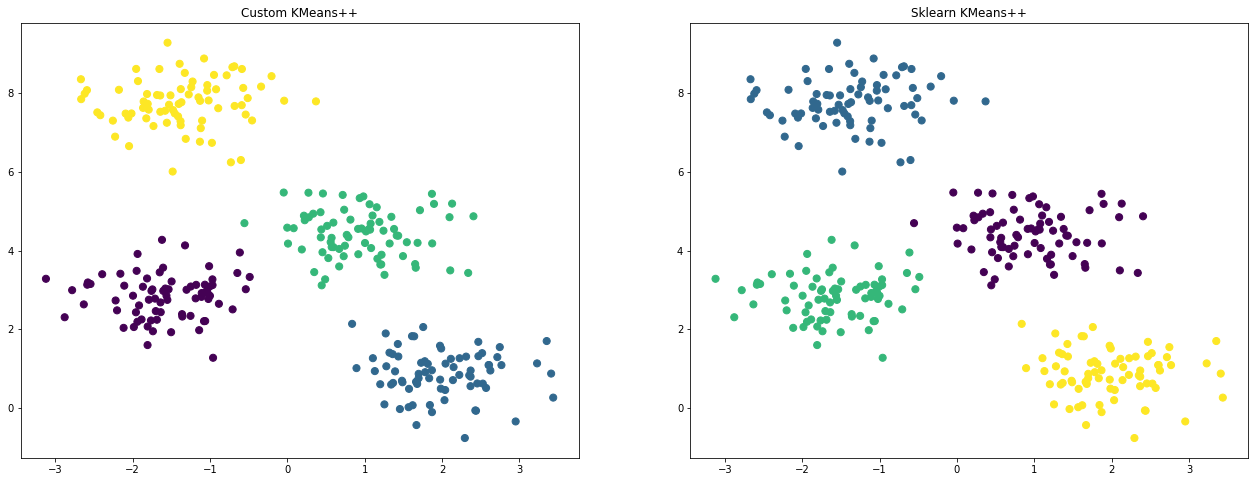

In [109]:
from sklearn.cluster import KMeans as SklearnKMeans

kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
predictions = kmeans.predict(X)

kmeans_plus_plus = SklearnKMeans(n_clusters=4, init='k-means++')
kmeans_plus_plus.fit(X)
predictions_plus_plus = kmeans_plus_plus.predict(X)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
ax1.scatter(X[:, 0], X[:, 1], c=predictions, s=50, cmap='viridis')
ax1.set_title('Custom KMeans++')
ax2.scatter(X[:, 0], X[:, 1], c=predictions_plus_plus, s=50, cmap='viridis')
ax2.set_title('Sklearn KMeans++')
plt.show()

# Task 3. DBSCAN

In [30]:
class DBSCAN(BaseCluster):
    def __init__(self, eps=0.5, min_samples=5):
        self.eps = eps
        self.min_samples = min_samples
        self.labels = None
        self.data_ = None

    def fit(self, data):
        self.data_ = data
        self.labels = np.zeros(len(data), dtype=int)
        cluster_id = 0

        for i, point in enumerate(data):
            if self.labels[i] != 0:
                continue

            neighbors = self.region_query(data, point)
            if len(neighbors) < self.min_samples:
                self.labels[i] = -1
                continue

            cluster_id += 1
            self.labels[i] = cluster_id

            while len(neighbors) > 0:
                neighbor = neighbors.pop()
                if self.labels[neighbor] == -1:
                    self.labels[neighbor] = cluster_id # border point
                if self.labels[neighbor] != 0:
                    continue

                self.labels[neighbor] = cluster_id
                new_neighbors = self.region_query(data, data[neighbor])
                if len(new_neighbors) >= self.min_samples:
                    neighbors.extend(new_neighbors)

    def predict(self, data):
        # first use region query to find neighbors
        # if number of neighbors >= min_samples, use cluster id with the most points in the neighborhood
        # if number of neighbors < min_samples, assign -1

        predictions = np.zeros(len(data), dtype=int)
        for i, point in enumerate(data):
            neighbors = self.region_query(self.data_, point)
            if len(neighbors) < self.min_samples:
                predictions[i] = -1
                continue

            cluster_ids = [self.labels[neighbor] for neighbor in neighbors]
            predictions[i] = max(set(cluster_ids), key=cluster_ids.count)

        return predictions

    def region_query(self, data, point):
        distances = np.linalg.norm(data - point, axis=1)
        return list(np.where(distances <= self.eps)[0])

## Comparison of Custom DBSCAN with DBSCAN from sklearn

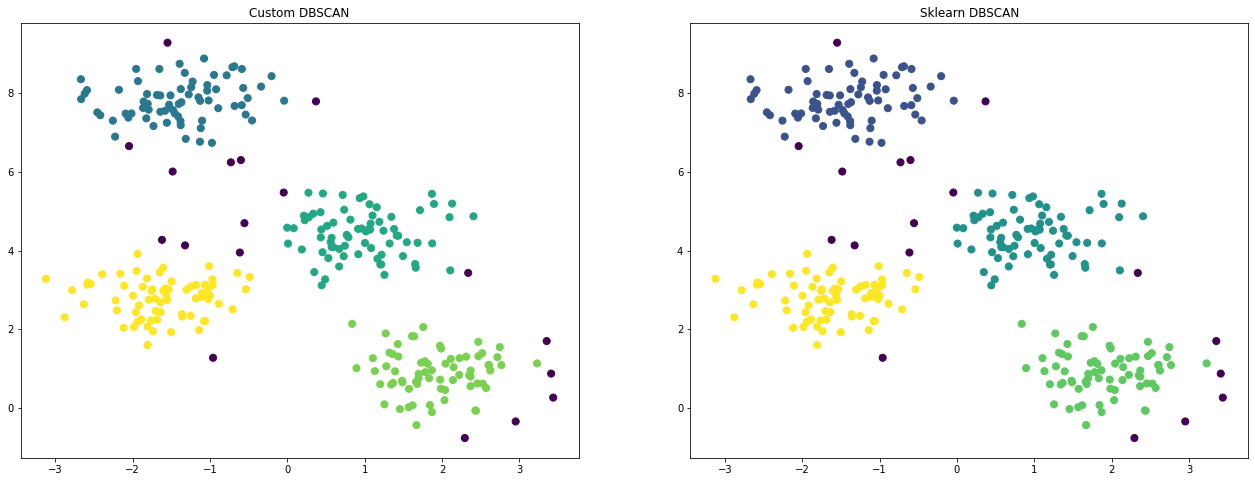

In [33]:
from sklearn.cluster import DBSCAN as SklearnDBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X)
predictions = dbscan.labels

sklearn_dbscan = SklearnDBSCAN(eps=0.5, min_samples=5)
sklearn_dbscan.fit(X)
predictions_sklearn = sklearn_dbscan.labels_

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
ax1.scatter(X[:, 0], X[:, 1], c=predictions, s=50, cmap='viridis')
ax1.set_title('Custom DBSCAN')
ax2.scatter(X[:, 0], X[:, 1], c=predictions_sklearn, s=50, cmap='viridis')
ax2.set_title('Sklearn DBSCAN')
plt.show()

## Comparison of DBSCAN with KMeans++ on make_blobs, make_circles, make_moons datasets

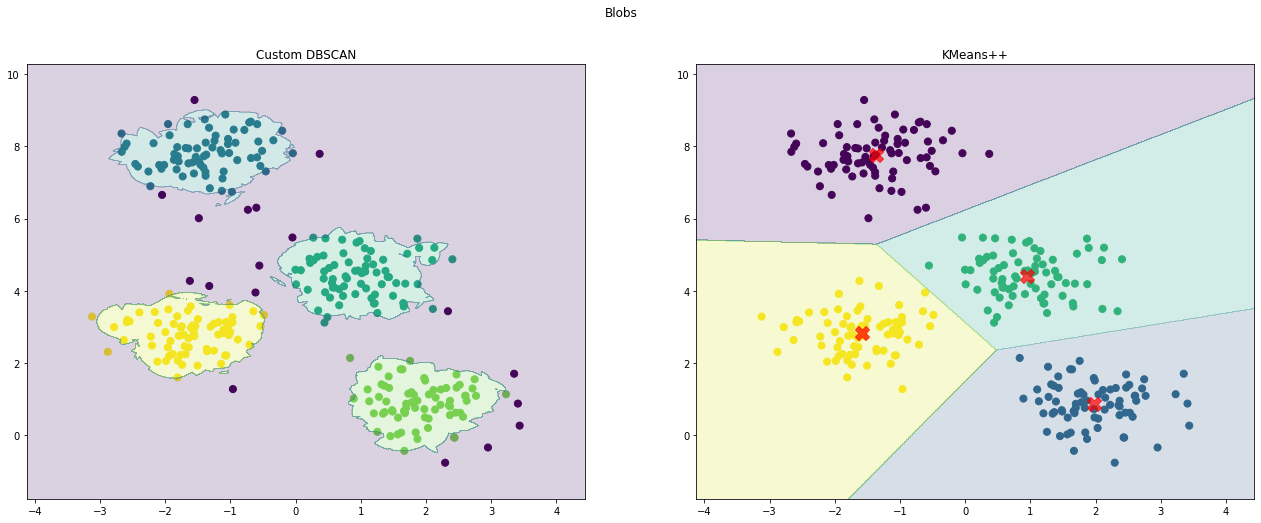

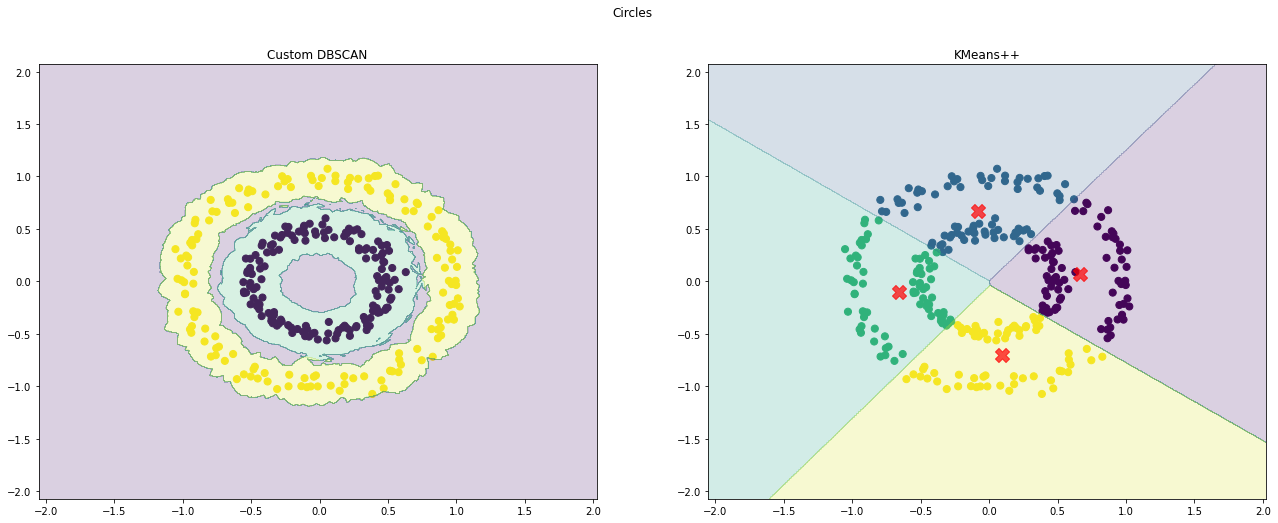

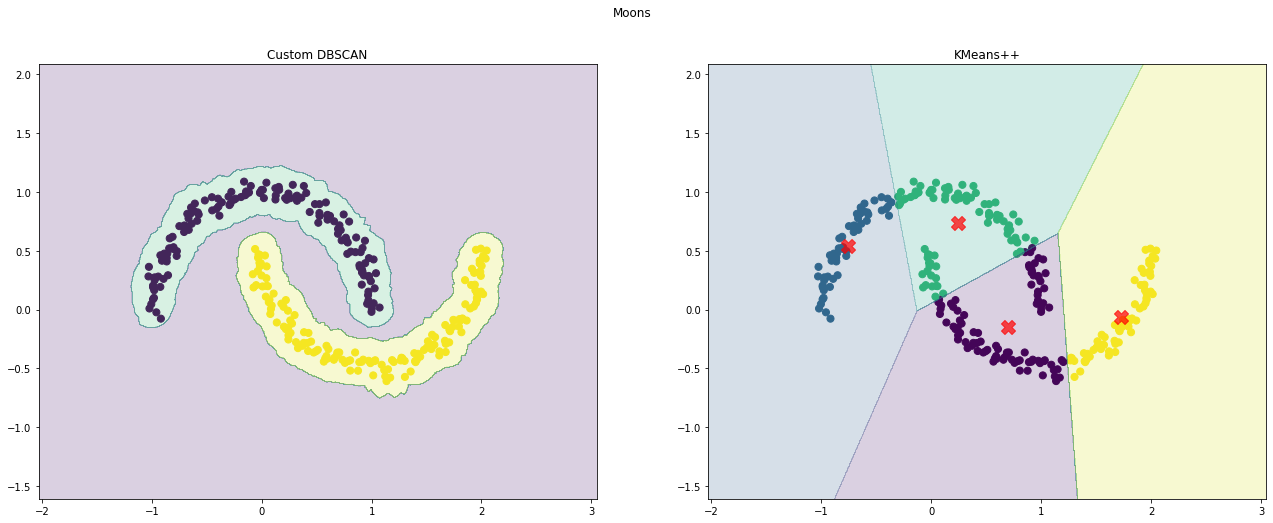

In [40]:
from sklearn.datasets import make_circles, make_moons

X_blobs, _ = make_blobs(n_samples=300, centers=4, cluster_std=0.60, random_state=0)
X_circles, _ = make_circles(n_samples=300, factor=0.5, noise=0.05)
X_moons, _ = make_moons(n_samples=300, noise=0.05)

datasets = [X_blobs, X_circles, X_moons]
titles = ['Blobs', 'Circles', 'Moons']
hyperparameters = [(0.5, 5), (0.2, 4), (0.2, 4)]

for data, title, hyperparameter in zip(datasets, titles, hyperparameters):
    dbscan = DBSCAN(eps=hyperparameter[0], min_samples=hyperparameter[1])
    dbscan.fit(data)
    predictions = dbscan.labels

    kmeans_plus_plus = KMeansPlusPlus(n_clusters=4)
    kmeans_plus_plus.fit(data)
    predictions_plus_plus = kmeans_plus_plus.predict(data)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
    x_min, x_max = data[:, 0].min() - 1, data[:, 0].max() + 1
    y_min, y_max = data[:, 1].min() - 1, data[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))

    ax1.scatter(data[:, 0], data[:, 1], c=predictions, s=50, cmap='viridis')
    Z = dbscan.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax1.contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
    ax1.set_title('Custom DBSCAN')

    ax2.scatter(data[:, 0], data[:, 1], c=predictions_plus_plus, s=50, cmap='viridis')
    Z = kmeans_plus_plus.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax2.contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
    centroids = kmeans_plus_plus.centroids
    ax2.scatter(centroids[:, 0], centroids[:, 1], s=200, c='red', alpha=0.7, marker='X')
    ax2.set_title('KMeans++')
    plt.suptitle(title)
    plt.show()

# Task 4. Agglomerative Clustering

In [85]:
from itertools import combinations


class AgglomerativeClustering(BaseCluster):
    def __init__(self, n_clusters=2, linkage='single'):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.labels = None
        self.clusters = None
        self.cluster_map = None
        self.data_ = None
        self.Z = None

    def fit(self, data):
        self.data_ = data
        clusters = {i: [i] for i in range(len(data))}
        self.Z = np.zeros((len(data) - 1, 4))

        for i in range(len(data) - 1):
            closest_pair, closest_distance = self._find_closest_clusters(clusters, data)
            clusters, merged_cluster = self._merge_clusters(clusters, closest_pair, len(data) + i)

            self.Z[i] = [closest_pair[0], closest_pair[1], closest_distance, len(clusters[merged_cluster])]

        labels = np.zeros(len(data), dtype=int)
        clusters = {i: [i] for i in range(len(data))}
        for i in range(len(data) - self.n_clusters):
            cluster1, cluster2 = self.Z[i, :2].astype(int)
            clusters[len(data) + i] = clusters[cluster1] + clusters[cluster2]
            del clusters[cluster1]
            del clusters[cluster2]

        self.clusters = clusters
        self.cluster_map = {}
        keys = list(clusters.keys())
        for i, key in enumerate(keys):
            labels[clusters[key]] = i
            self.cluster_map[key] = i

        self.labels = labels

    def predict(self, data):
        # find the closest cluster for each point
        predictions = np.zeros(len(data), dtype=int)
        for i, point in enumerate(data):
            distances = self._get_distances(point, self.clusters, self.data_)
            predictions[i] = self.cluster_map[min(distances, key=distances.get)]

        return predictions

    def _find_closest_clusters(self, clusters, data):
        closest_pair = None
        closest_distance = np.inf

        for cluster1, cluster2 in combinations(clusters.keys(), 2):
            distance = self._calculate_distance(data[clusters[cluster1]], data[clusters[cluster2]])
            if distance < closest_distance:
                closest_pair = (cluster1, cluster2)
                closest_distance = distance

        return closest_pair, closest_distance

    def _merge_clusters(self, clusters, closest_pair, index):
        cluster1, cluster2 = closest_pair
        clusters[index] = clusters[cluster1] + clusters[cluster2]
        del clusters[cluster1]
        del clusters[cluster2]
        return clusters, index

    def _calculate_distance(self, cluster1, cluster2):
        if self.linkage == 'single':
            return self._single_linkage(cluster1, cluster2)
        elif self.linkage == 'complete':
            return self._complete_linkage(cluster1, cluster2)
        elif self.linkage == 'average':
            return self._average_linkage(cluster1, cluster2)
        else:
            raise ValueError('Linkage should be one of the following: single, complete, average')

    def _single_linkage(self, cluster1, cluster2):
        return min(np.linalg.norm(x1 - x2) for x1 in cluster1 for x2 in cluster2)

    def _complete_linkage(self, cluster1, cluster2):
        return max(np.linalg.norm(x1 - x2) for x1 in cluster1 for x2 in cluster2)

    def _average_linkage(self, cluster1, cluster2):
        return sum(np.linalg.norm(x1 - x2) for x1 in cluster1 for x2 in cluster2) / (len(cluster1) * len(cluster2))

    def _get_distances(self, point, clusters, data):
        return {cluster: self._calculate_distance(data[clusters[cluster]], [point]) for cluster in clusters}

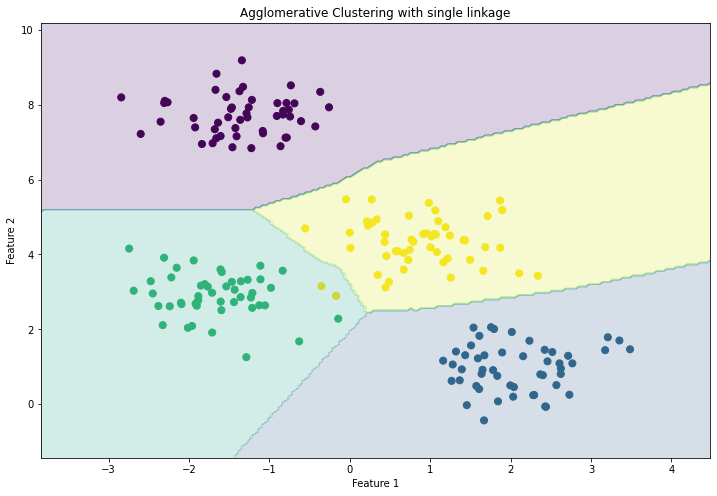

In [98]:
X, _ = make_blobs(n_samples=200, centers=4, cluster_std=0.60, random_state=0)

agglomerative = AgglomerativeClustering(n_clusters=4, linkage='complete')
agglomerative.fit(X)
predictions = agglomerative.labels

plot_clusters(X, predictions, None, agglomerative, n_points=200, title='Agglomerative Clustering with single linkage')

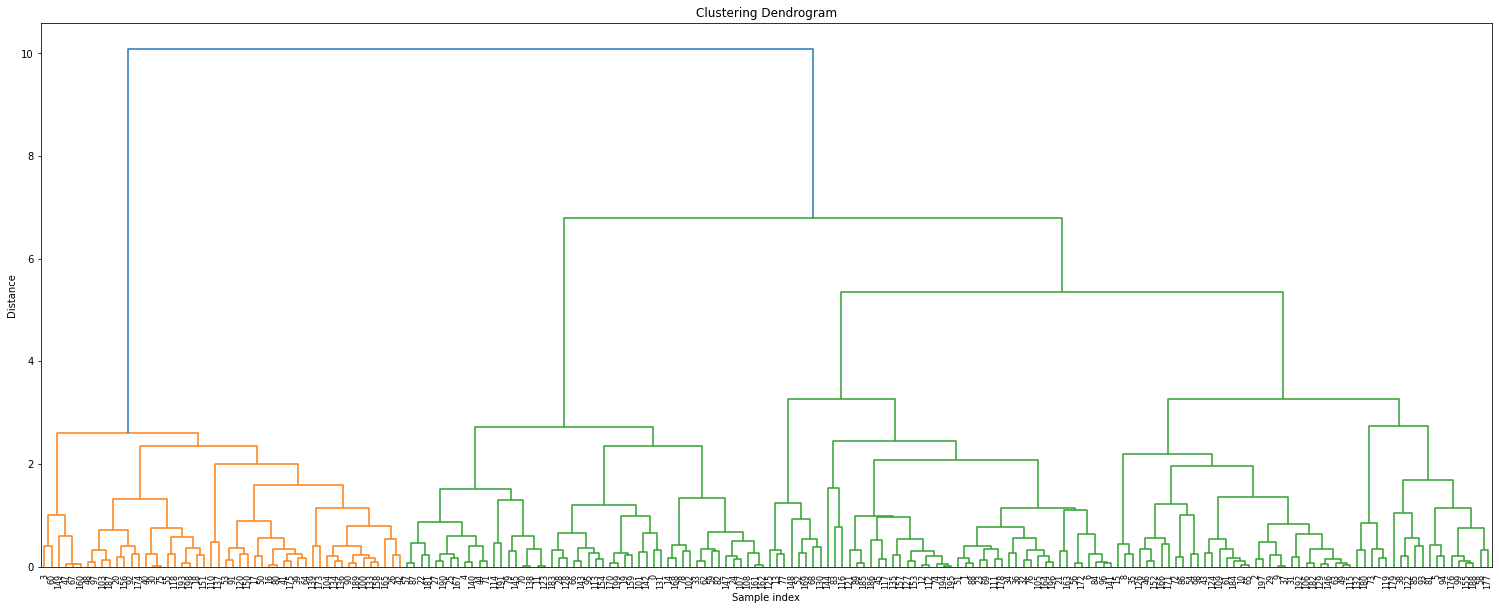

In [99]:
from scipy.cluster.hierarchy import dendrogram

plt.figure(figsize=(26, 10))
plt.title('Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
dendrogram(agglomerative.Z, leaf_rotation=90., leaf_font_size=8.)
plt.show()

## Comparison with AgglomerativeClustering from sklearn on make_blobs dataset

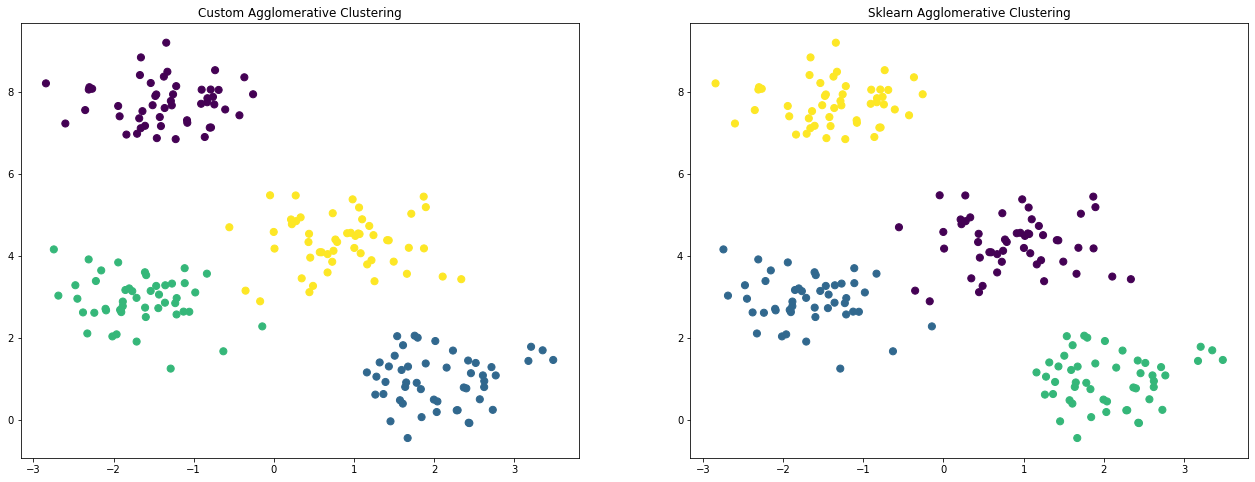

In [96]:
from sklearn.cluster import AgglomerativeClustering as SklearnAgglomerativeClustering

sklearn_agglomerative = SklearnAgglomerativeClustering(n_clusters=4, linkage='complete')
sklearn_agglomerative.fit(X)
predictions_sklearn = sklearn_agglomerative.labels_

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
ax1.scatter(X[:, 0], X[:, 1], c=predictions, s=50, cmap='viridis')
ax1.set_title('Custom Agglomerative Clustering')
ax2.scatter(X[:, 0], X[:, 1], c=predictions_sklearn, s=50, cmap='viridis')
ax2.set_title('Sklearn Agglomerative Clustering')
plt.show()

## Comparison of different linkages

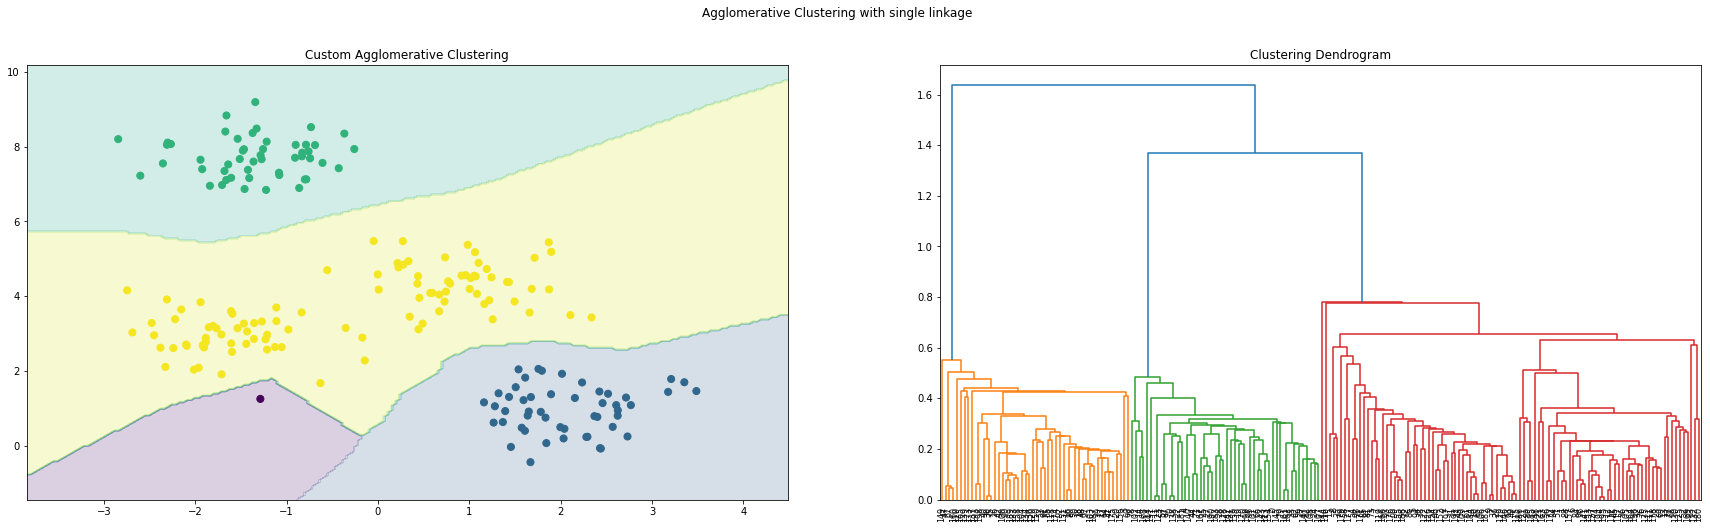

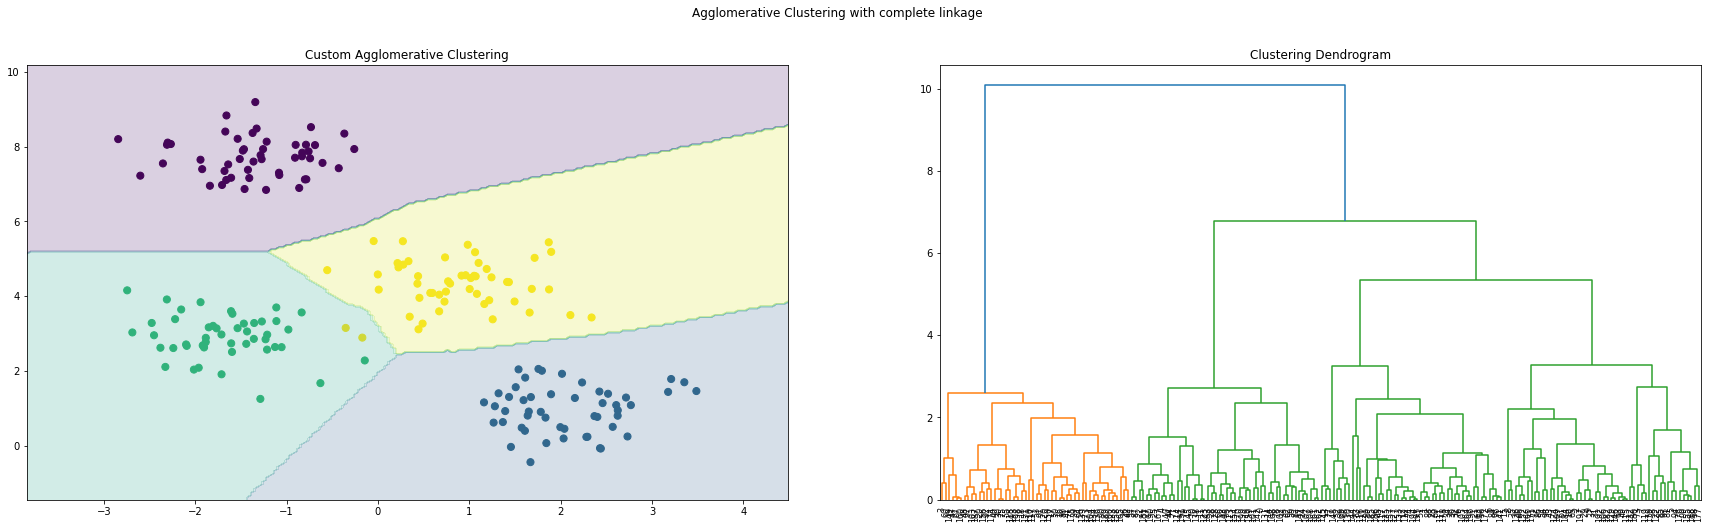

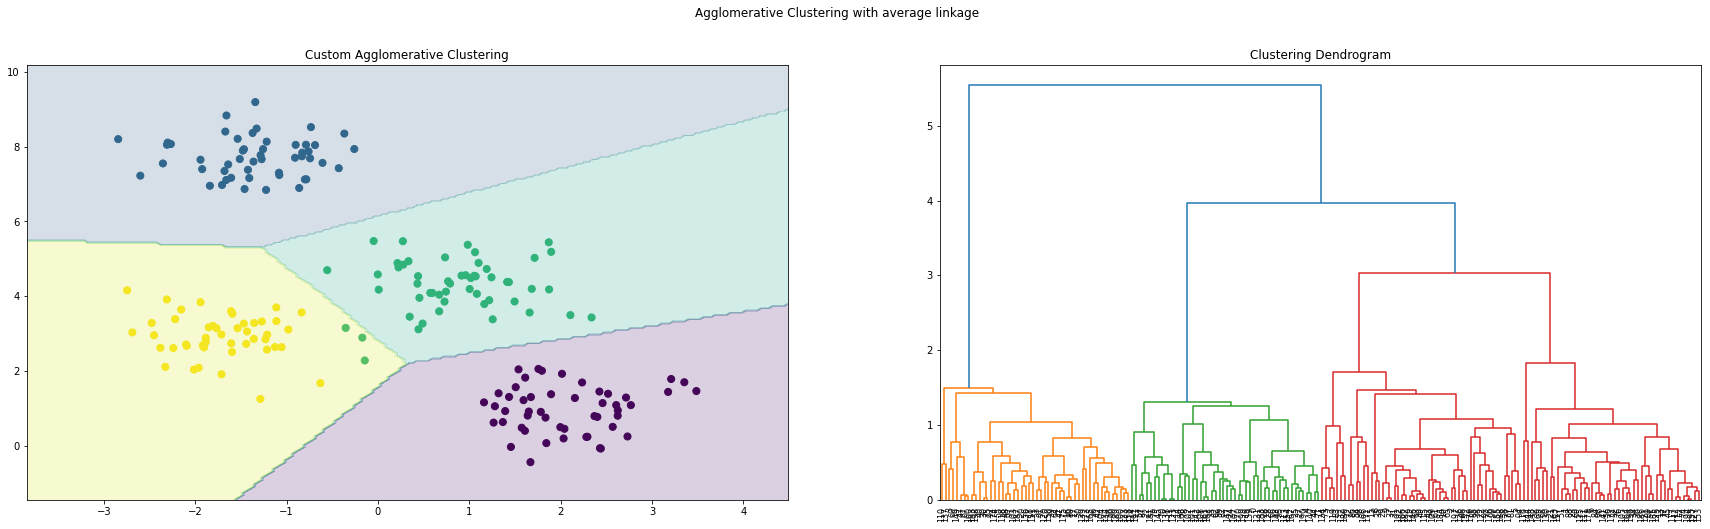

In [103]:
linkages = ['single', 'complete', 'average']

for linkage in linkages:
    agglomerative = AgglomerativeClustering(n_clusters=4, linkage=linkage)
    agglomerative.fit(X)
    predictions = agglomerative.labels

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 8))
    ax1.scatter(X[:, 0], X[:, 1], c=predictions, s=50, cmap='viridis')
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    Z = agglomerative.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax1.contourf(xx, yy, Z, alpha=0.2, cmap='viridis')
    ax1.set_title('Custom Agglomerative Clustering'.format(linkage))

    # dendrogram
    ax2.set_title('Clustering Dendrogram'.format(linkage))
    dendrogram(agglomerative.Z, leaf_rotation=90., leaf_font_size=8., ax=ax2)

    plt.suptitle('Agglomerative Clustering with {} linkage'.format(linkage))
    plt.show()